# Import des Netzwerks für das Modell

### Einrichtung

In [22]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
import random

import pypsa

%matplotlib inline

## Setup

Setting up all the network's main components

All of the data is taken from another thesis, written at the same chair at TU Berlin as this one. The data is provided in the form of excel-files and is read using methods from pandas.

### Variables

In [23]:
nw = pypsa.Network()

In [24]:
nw.set_snapshots([p for p in range(10)])

In [25]:
cur_path = r"C:\Users\janni\OneDrive\TU Berlin\4 - Abschlussarbeiten\01 - Bachelorarbeit\modell\data\\"

Setting the paths for the data

In [26]:
ex1 = pd.ExcelFile(cur_path + "map_cities.xlsx")
ex2 = pd.ExcelFile(cur_path + "map_countries.xlsx")

all_gens = pd.read_excel(cur_path + "Kraftwerksliste_ÜNB_Entwurf_Szenariorahmen_2030_V2019.xlsx")
agg_fleet = pd.read_excel(cur_path + "power_grid_mapping_generator_fleet.xlsx", sheet_name="fleet_fuel", header=0, usecols="B:D")

### Setup within Germany

In [27]:
df_buses = pd.read_excel(ex1, sheet_name="buses", header=0, usecols="B:D")
df_lines = pd.read_excel(ex1, sheet_name="lines", header=0, usecols="B:D")

### Setup abroad

In [28]:
df_countries = pd.read_excel(ex2, sheet_name="buses", header=0, usecols="B:D")
df_countries_lines = pd.read_excel(ex2, sheet_name="lines", header=0, usecols="B:D")
df_buses = df_buses.append(df_countries).reset_index(drop=True)
df_lines = df_lines.append(df_countries_lines).reset_index(drop=True)

Calculating the length of each line by Pythagoras.
The factor enables converting the distance in lattitude/longitude to kilometers

In [29]:
df_lines["length"] = 0
df_lines["x"]=0.0001
df_lines["s_nom"]=25000
factor_coords_to_km = 111

for i in range(len(df_lines)):
    x_val = df_buses["x"][df_lines["bus0"][i]] - df_buses["x"][df_lines["bus1"][i]]
    y_val = df_buses["y"][df_lines["bus0"][i]] - df_buses["y"][df_lines["bus1"][i]]
    df_lines.at[i, "length"] = (math.sqrt(x_val**2 + y_val**2) * factor_coords_to_km)

In [30]:
pypsa.io.import_components_from_dataframe(nw, df_buses, "Bus")
pypsa.io.import_components_from_dataframe(nw, df_lines, "Line")

### Map topography

(<matplotlib.collections.PathCollection at 0x24b075416d8>,
 <matplotlib.collections.LineCollection at 0x24b0bc67358>)

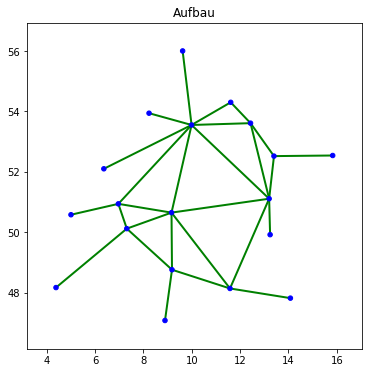

In [31]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches(6,6)

nw.plot(bus_sizes=20, title="Aufbau")

### Generators

In [32]:
agg_fleet.rename(columns={"fuel":"carrier",
                          "capacity[MW]":"p_nom"}, inplace=True)
agg_fleet["committable"] = True

In [33]:
agg_fleet["bus"] = 0

for j in range(len(agg_fleet)):
    # find out index of "Bundesland" of each generator
    indices = [i for i, s in enumerate(nw.buses.name) if agg_fleet["state"][j] in s]
    agg_fleet.at[j, "bus"] = indices[0]

Add correct busnumber to each generator by comparing regions from df with buses

In [34]:
pypsa.io.import_components_from_dataframe(nw, agg_fleet, "Generator")

Manually adding Germany's offshore windparks to the system, waiting for more data

### Temporary Loads for testing

In [35]:
nw.generators.p_nom.sum()

68589.0

In [36]:
for i in range(8):
    nw.add("Load", "myload{0}".format(i), bus=i, p_set=[random.randint(2000, 8000) for p in range(len(nw.snapshots))])

## Linear Optimal Power Flow (incl. unit commitment for generators)

In [37]:
nw.lopf(solver_name="gurobi")

INFO:pypsa.pf:Slack bus for sub-network 0 is 0
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1121
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 1671
  Number of variables: 1121
  Number of binary variables: 330
  Number of integer variables: 330
  Number of continuous variables: 791
  Number of nonzeros: 3221
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimali

('ok', 'optimal')

## Visualization

In [39]:
gen_outs = nw.generators_t.p
caps_by_carrier = nw.generators.groupby("carrier")["p_nom"].sum()
gen_pot_remaining = nw.generators.p_nom - gen_outs
power_by_carrier = nw.generators_t.p.groupby(nw.generators.carrier, axis=1).sum()

Line graph to display the dispatched amount of energy per plant

Text(0,0.5,'MW')

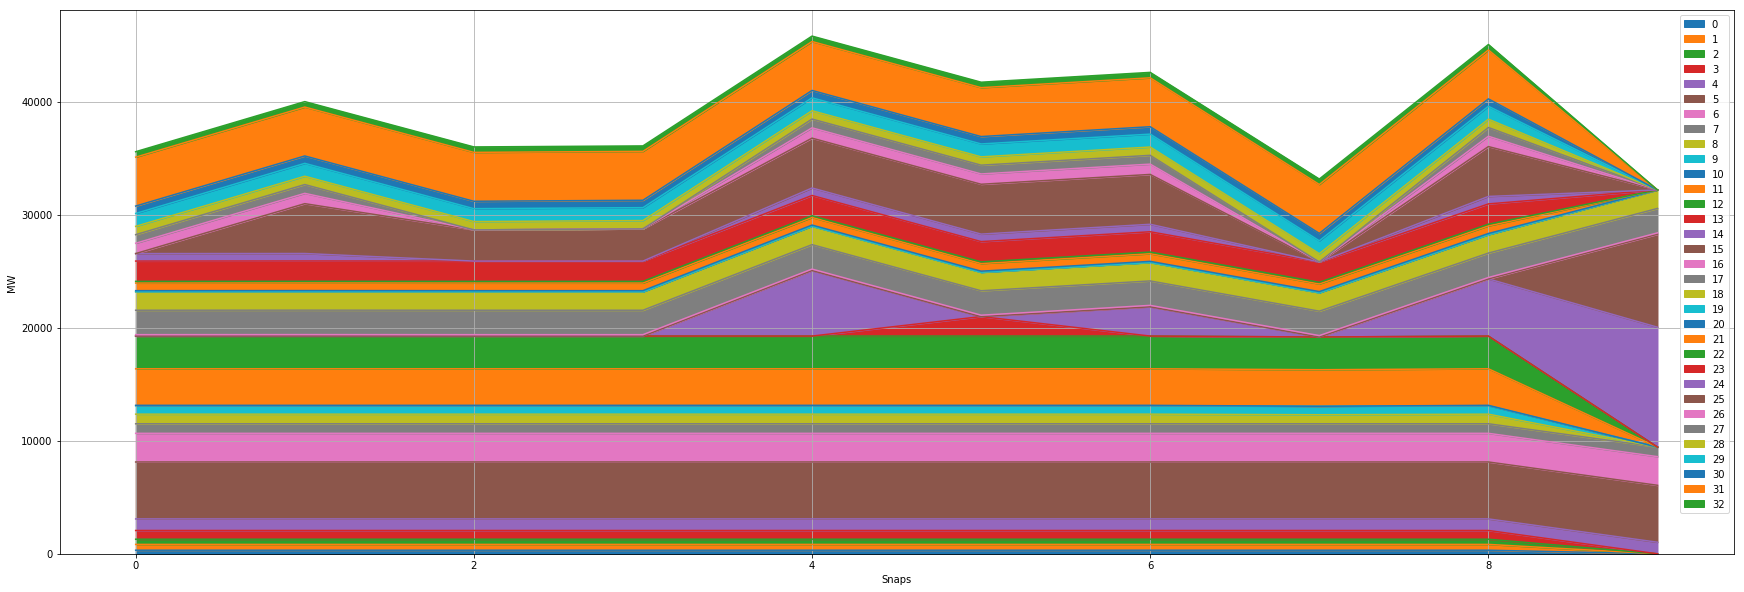

In [40]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(30,10)

(nw.generators_t.p).plot(kind="area",ax=ax, grid=True)

ax.set_xlabel("Snaps")
ax.set_ylabel("MW")

Text(0,0.5,'MW')

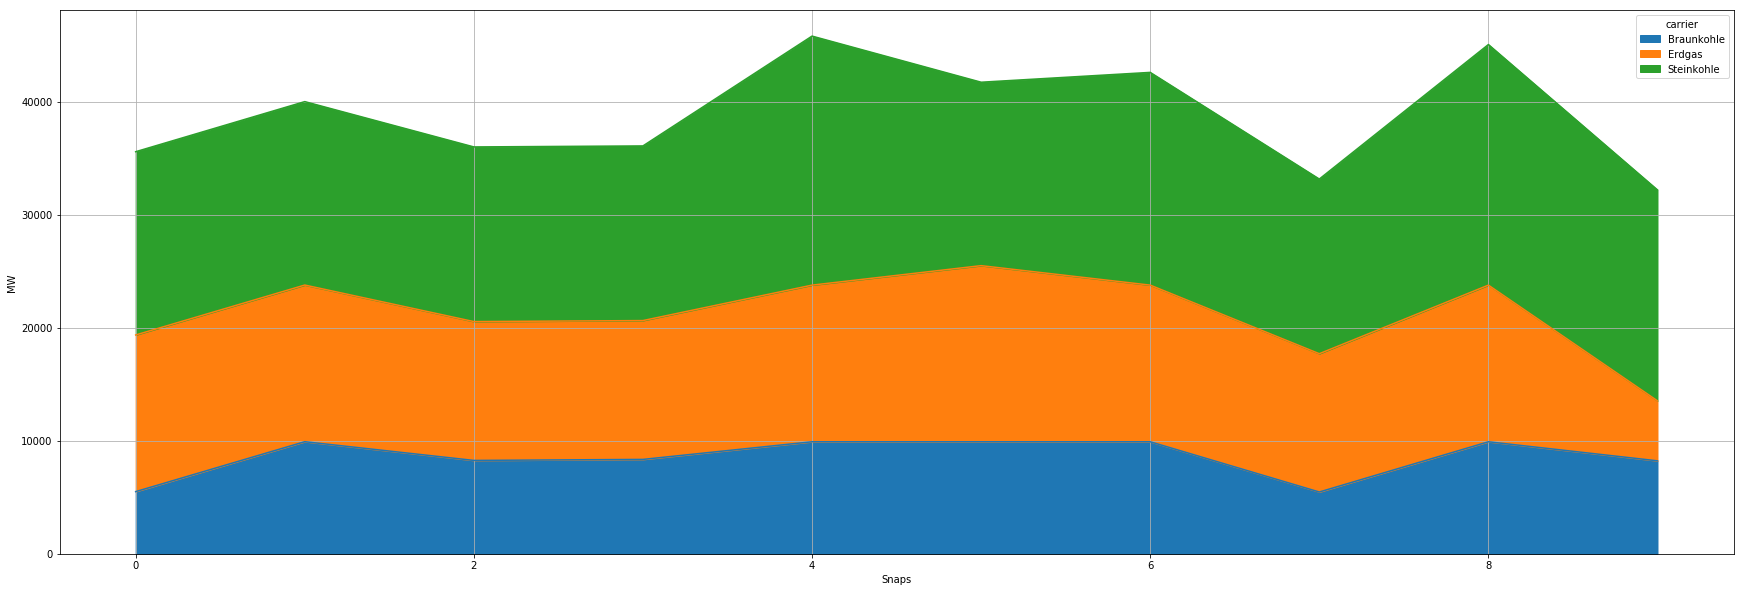

In [41]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(30,10)

power_by_carrier.plot(kind="area",ax=ax, grid=True)

ax.set_xlabel("Snaps")
ax.set_ylabel("MW")